# Bootstrap analysis of phenotypic data from HCP

In [2]:
clear all
% build path
addpath(genpath('../Misc'))
build_path  niak psom hcp

Adding library niak to the search path.

Adding library psom to the search path.

Adding library hcp to the search path.



In [3]:
% Read pheno
[TAB,LABELS_X,LABELS_Y,LABELS_ID] = niak_read_csv('/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno/hcp_all_pheno_clean_nonan_norm.csv');
y=TAB;

We compute the spatial correlation matrix (across subjects) to see how the cluster structure looks.  

In [16]:
nb_cluster =9;   % # of clusters 

ans =  1


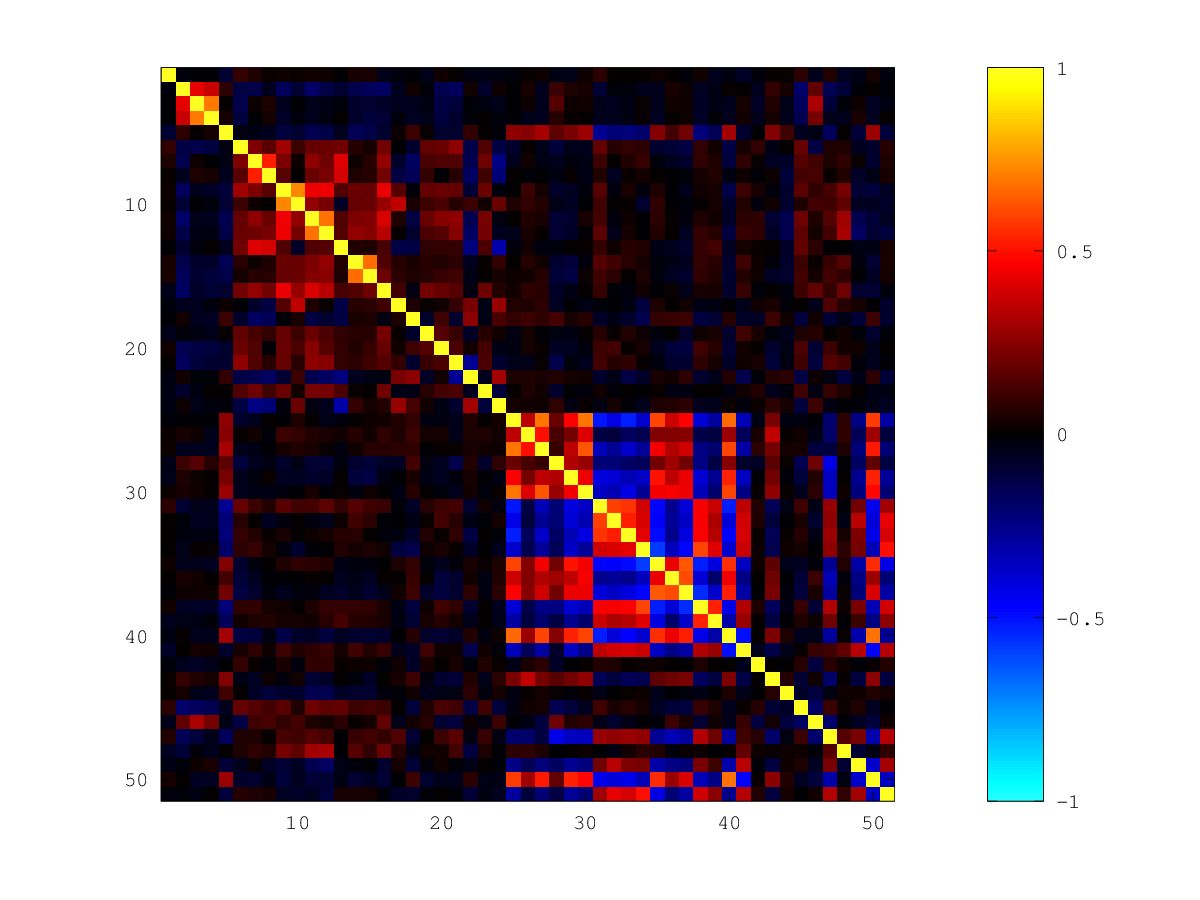

In [5]:
R = corr(y);
title('Spatial correlation matrix')
niak_visu_matrix(R), axis square

the cluster structure is clear, but noisy. Let's run a hierarchical clustering and see if we can recover it. 

     Percentage done : 0 6 10 16 20 26 30 36 40 46 50 56 60 66 70 76 80 86 90 96 100 Done ! 


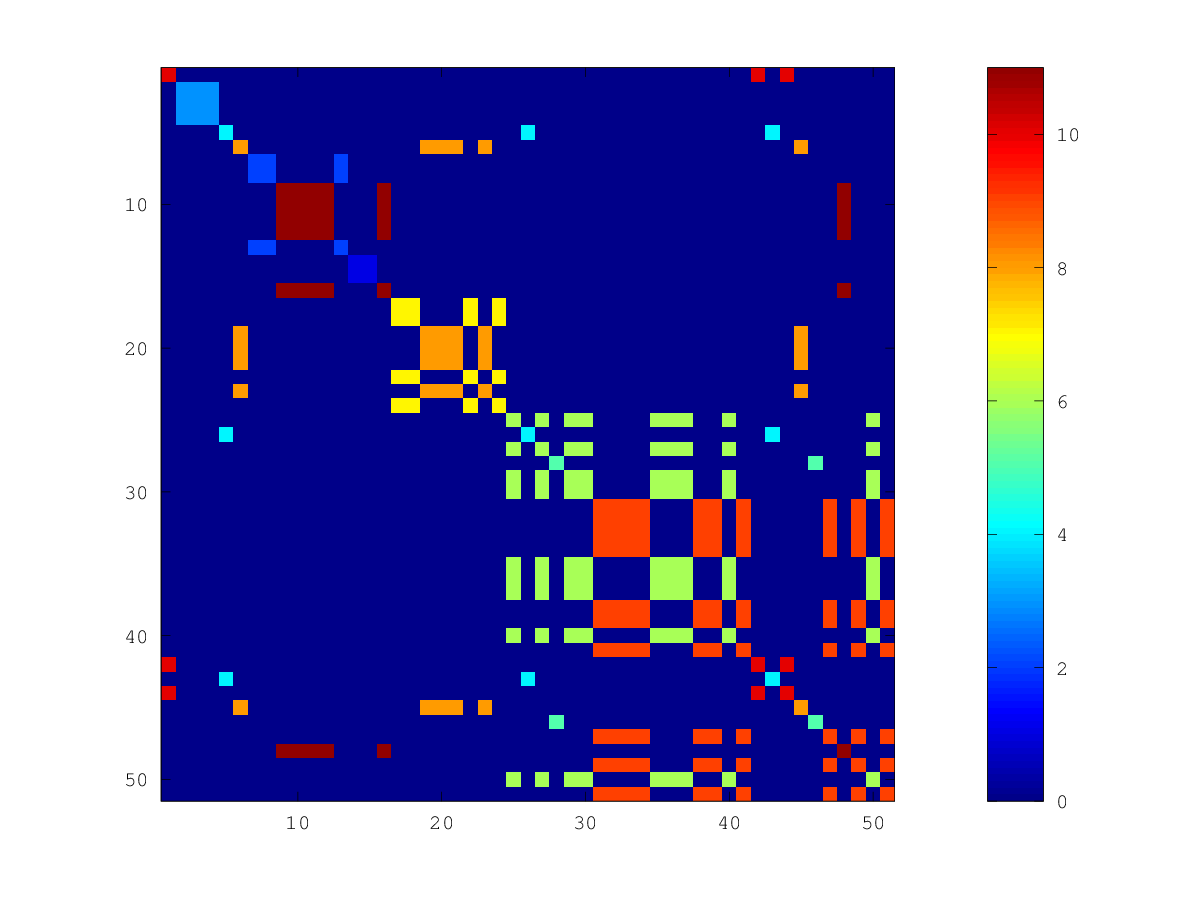

In [6]:
hier = niak_hierarchical_clustering(R); % The similarity-based hierarchical clustering
part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); % threshold the hierarchy to get 3 clusters
niak_visu_part(part) % visualize the partition

If the clustering had done a perfect job, we would have squares on the diagonal.let's odre it

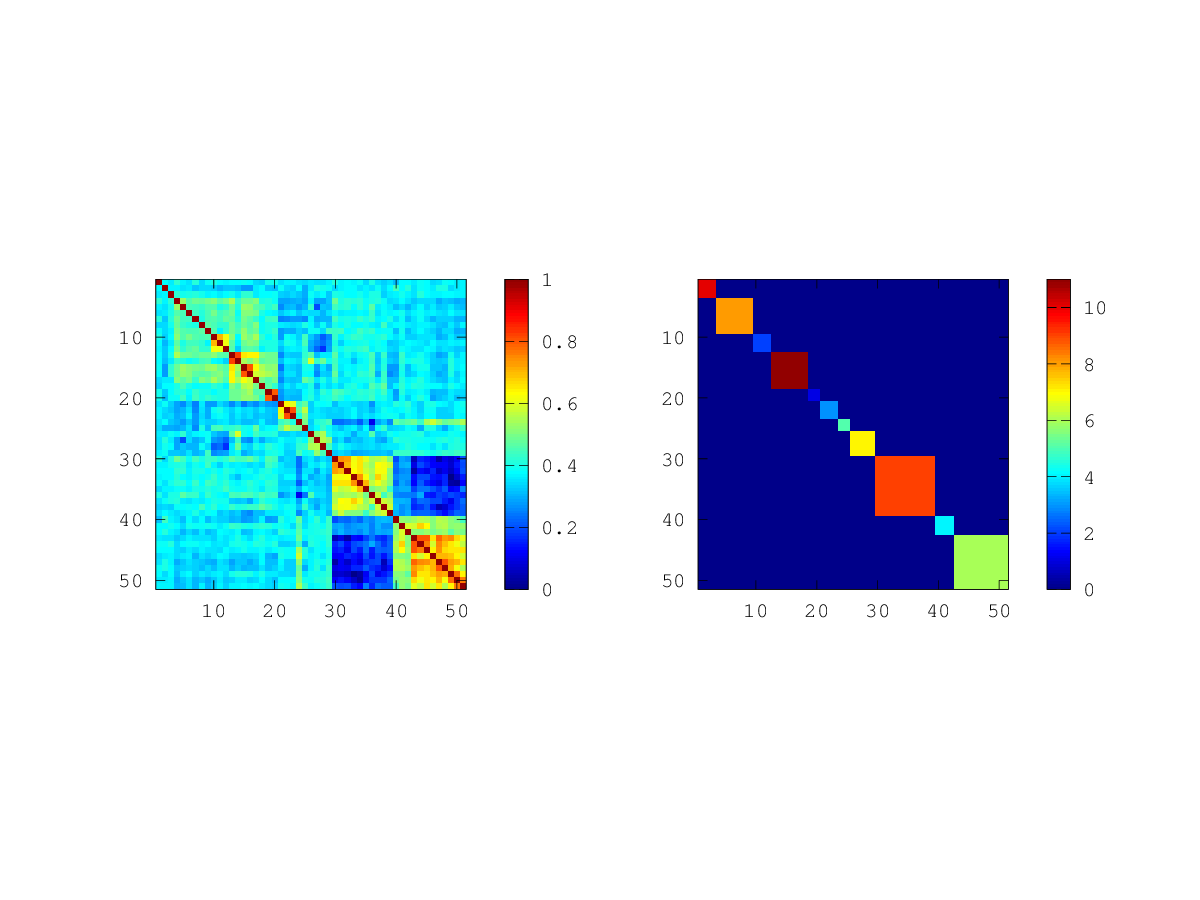

In [7]:
order = niak_hier2order(hier); % order the regions based on the hierarchy
subplot(1,2,1)
% Re-order the correlation matrix
title('re-ordered correlation matrix')
imagesc(R(order,order)), axis square, colorbar
subplot(1,2,2)
% Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part(order)), axis square

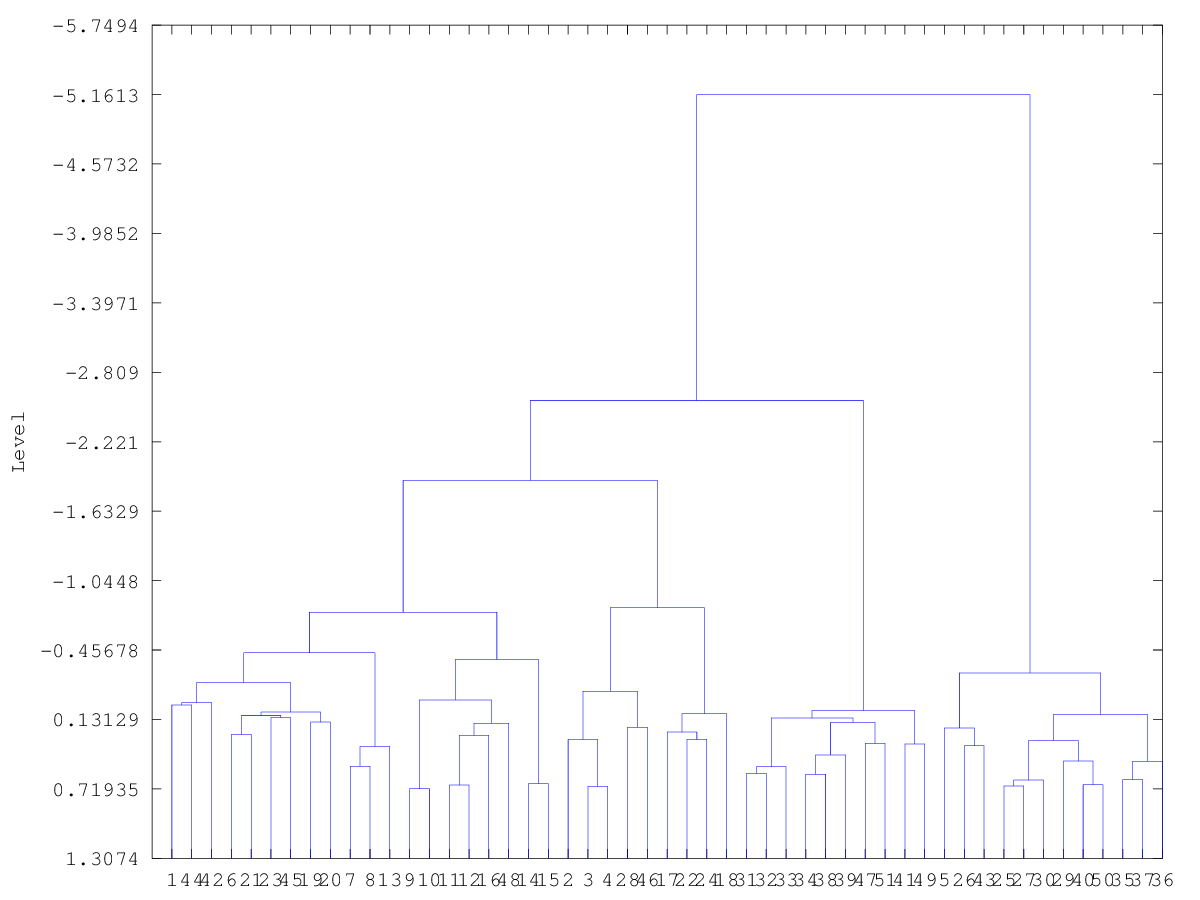

In [8]:
niak_visu_dendrogram(hier)

## boostrap analysis of stable clusters
 

In [9]:
nb_samp = 100;
opt_b.block_length = 1; % That's a parameter for the bootstrap. We treat the subjects as independent observations. 
for ss = 1:nb_samp
    niak_progress(ss,nb_samp)
    y_s = niak_bootstrap_tseries(y,opt_b); % Bootstrap the subjects
    R_s = corr(y_s); % compute the correlation matrix for the bootstrap sample
    hier = niak_hierarchical_clustering(R_s,struct('flag_verbose',false)); % replication the hierarchical clustering
    part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); % Cut the hierarchy to get clusters
    mat = niak_part2mat(part,true); % convert the partition into an adjacency matrix
    if ss == 1; stab = mat; else stab = stab+mat; end; % Add all adjacency matrices
end
stab = stab / nb_samp; % Divide by the number of replications to get the stability matrix

    Percentage done: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100


Let's have a look at the stability matrix:

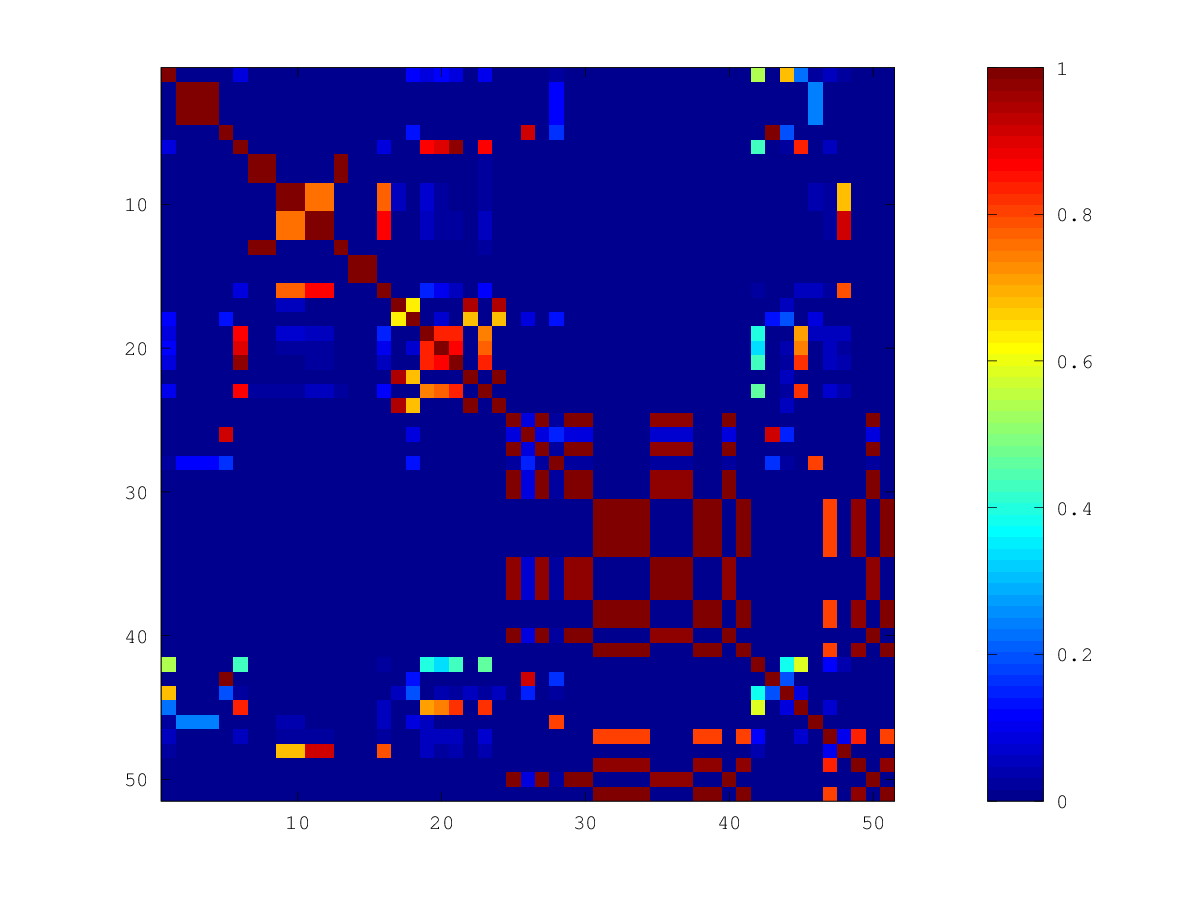

In [10]:
imagesc(stab), axis square, colormap(jet), colorbar

     Percentage done : 0 6 10 16 20 26 30 36 40 46 50 56 60 66 70 76 80 86 90 96 100 Done ! 


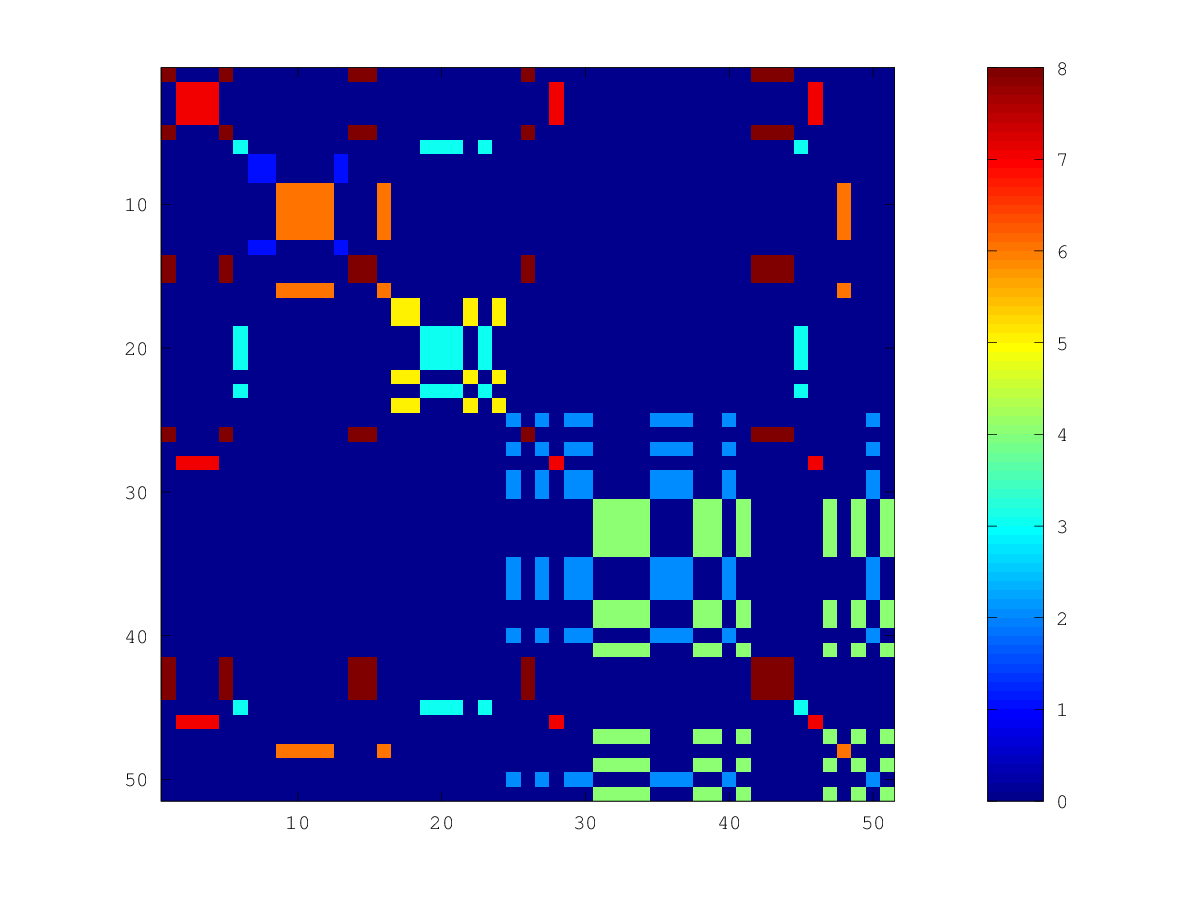

In [25]:
nb_cluster =8;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab); % run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); % cut the consensus hierarchy
niak_visu_part(part_consensus), axis square, colormap(jet) % visualize the consensus partition

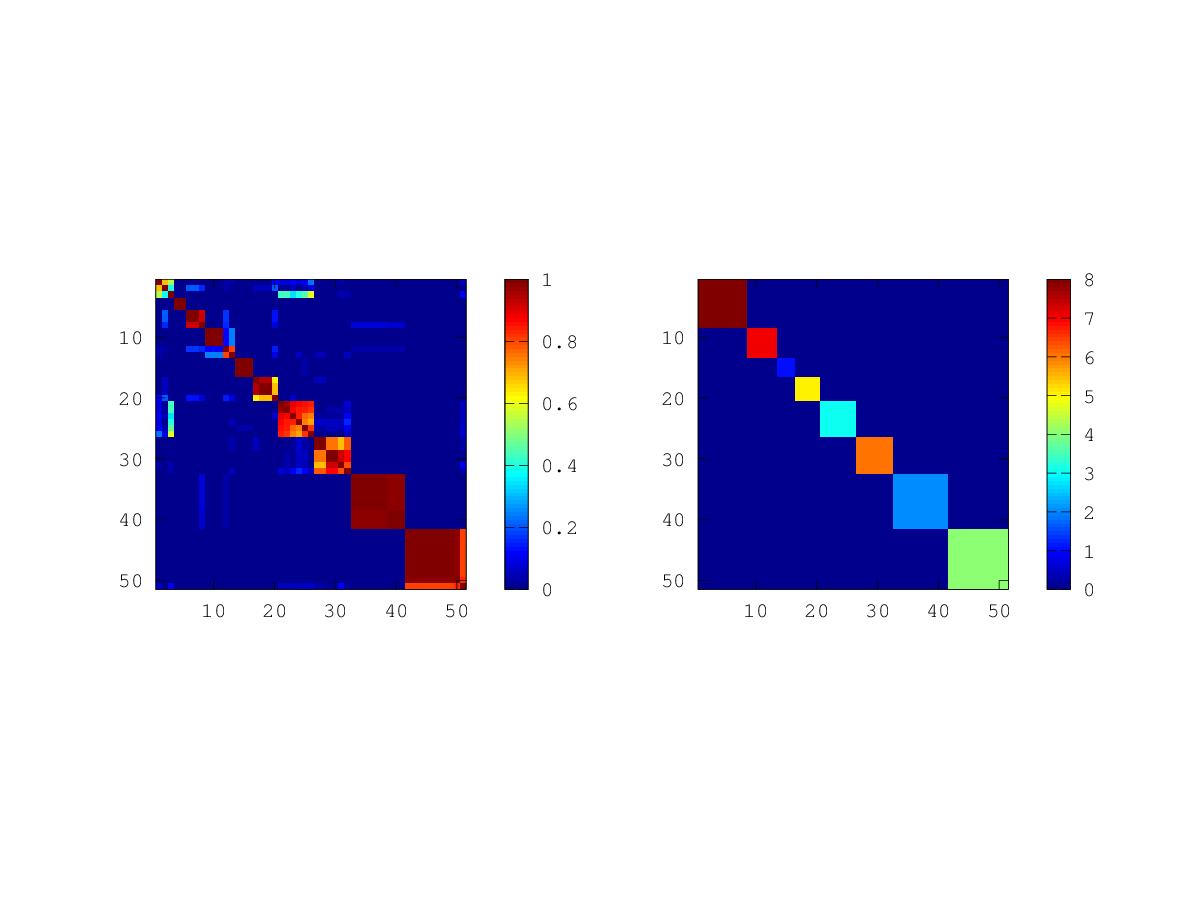

In [26]:
order_consensus = niak_hier2order(hier_consensus); % order the regions based on the hierarchy
subplot(1,2,1)
% Re-order the correlation matrix
title('re-ordered consensus matrix')
imagesc(stab(order_consensus,order_consensus)), axis square, colorbar
subplot(1,2,2)
% Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part_consensus(order_consensus)), axis square

In [27]:
%niak_visu_dendrogram(hier_consensus)

ans =  1


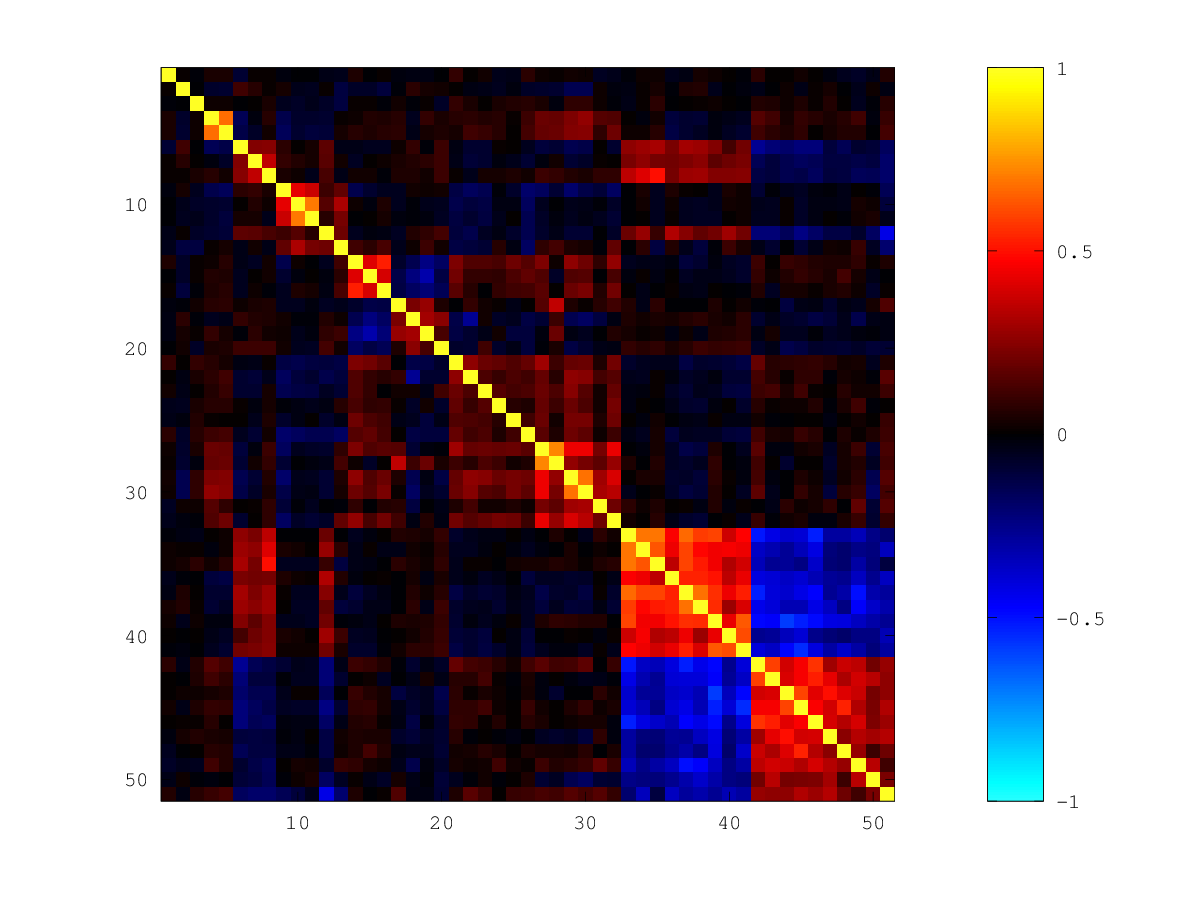

In [28]:
% Re-order the correlation matrix
title('re-ordered correlation matrix')
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar


In [29]:
% calculate the mean cluster and save it
stack = [];
labels_y_order = LABELS_Y( order_consensus);
part_consensus_order = part_consensus(order_consensus);
y_order = y(:,order_consensus);
for ii = 1:nb_cluster
    fprintf('Cluster %i: \n',ii);
    label_y{ii} = sprintf('cluster_%i',ii);
    mask = zeros(size(part_consensus_order));
    mask = part_consensus_order == ii;
    mean_clust = mean(y_order(:,mask),2);
    stack = [stack mean_clust];
    labels_pheno = labels_y_order(mask);
    for ss = 1:size(labels_pheno)(1)
        fprintf('     %s \n',labels_pheno{ss})
    end
end
% save clustred pheno to csv
opt.labels_y = label_y;
opt.labels_x  = LABELS_X;
opt.labels_id = 'Subject';
niak_write_csv('/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno/hcp_bootstraped_pheno_nonan_norm.csv',...
stack,opt);

Cluster 1: 
     CardSort_Unadj 
     ProcSpeed_Unadj 
     Flanker_Unadj 
Cluster 2: 
     Sadness_Unadj 
     AngAffect_Unadj 
     FearAffect_Unadj 
     AngHostil_Unadj 
     PercStress_Unadj 
     NEOFAC_N 
     Loneliness_Unadj 
     PercHostil_Unadj 
     PercReject_Unadj 
Cluster 3: 
     PicSeq_Unadj 
     IWRD_TOT 
     SCPT_SPEC 
     SCPT_SEN 
     ER40_CR 
     Dexterity_Unadj 
Cluster 4: 
     LifeSatisf_Unadj 
     MeanPurp_Unadj 
     Friendship_Unadj 
     EmotSupp_Unadj 
     PosAffect_Unadj 
     NEOFAC_E 
     InstruSupp_Unadj 
     SelfEff_Unadj 
     NEOFAC_C 
     NEOFAC_A 
Cluster 5: 
     VSPLOT_CRTE 
     IWRD_RTC 
     ER40_CRT 
     SCPT_TPRT 
Cluster 6: 
     PMAT24_A_CR 
     PMAT24_A_RTCR 
     ReadEng_Unadj 
     PicVocab_Unadj 
     NEOFAC_O 
     VSPLOT_TC 
Cluster 7: 
     BMI 
     BPSystolic 
     BPDiastolic 
     AngAggr_Unadj 
     Strength_Unadj 
Cluster 8: 
     Handedness 
     Taste_Unadj 
     Odor_Unadj 
     DDisc_AUC_200 
     DDisc_AUC_4

```
XP: age_adj

Cluster 1: 
     BMI 
     BPDiastolic 
     BPSystolic 
Cluster 2: 
     DDisc_AUC_200 
     DDisc_AUC_40K 
Cluster 3: 
     CardSort_AgeAdj 
     Flanker_AgeAdj 
     ProcSpeed_AgeAdj 
Cluster 4: 
     PSQI_Score 
     PainInterf_Tscore 
     FearSomat_Unadj 
Cluster 5: 
     Sadness_Unadj 
     AngAffect_Unadj 
     NEOFAC_N 
     FearAffect_Unadj 
     AngHostil_Unadj 
     PercStress_Unadj 
     Loneliness_Unadj 
     PercHostil_Unadj 
     PercReject_Unadj 
Cluster 6: 
     AngAggr_Unadj 
     Strength_AgeAdj 
Cluster 7: 
     PicSeq_AgeAdj 
     IWRD_TOT 
     SCPT_SPEC 
     SCPT_SEN 
     ER40_CR 
     Dexterity_AgeAdj 
Cluster 8: 
     LifeSatisf_Unadj 
     MeanPurp_Unadj 
     PosAffect_Unadj 
     SelfEff_Unadj 
     NEOFAC_C 
     Friendship_Unadj 
     EmotSupp_Unadj 
     InstruSupp_Unadj 
     NEOFAC_E 
     NEOFAC_A 
Cluster 9: 
     VSPLOT_CRTE 
     IWRD_RTC 
     ER40_CRT 
     SCPT_TPRT 
Cluster 10: 
     PMAT24_A_CR 
     PMAT24_A_RTCR 
     ReadEng_AgeAdj 
     PicVocab_AgeAdj 
     NEOFAC_O 
     VSPLOT_TC 
Cluster 11: 
     Handedness 
     Taste_AgeAdj 
     Odor_AgeAdj ```

Old_result
```
Cluster 1: 
     Strength_Unadj 
Cluster 2: 
     Sadness_Unadj 
     FearAffect_Unadj 
     PercStress_Unadj 
     AngHostil_Unadj 
     PercReject_Unadj 
     PercHostil_Unadj 
     AngAffect_Unadj 
     Loneliness_Unadj 
     NEOFAC_N 
Cluster 3: 
     BMI 
     BPSystolic 
     BPDiastolic 
Cluster 4: 
     PMAT24_A_CR 
     VSPLOT_TC 
     PicVocab_Unadj 
     PMAT24_A_RTCR 
     ReadEng_Unadj 
     DDisc_AUC_200 
     DDisc_AUC_40K 
     NEOFAC_O 
Cluster 5: 
     VSPLOT_CRTE 
     SCPT_TPRT 
     IWRD_RTC 
     ER40_CRT 
     Noise_Comp 
Cluster 6: 
     PicSeq_Unadj 
     Dexterity_Unadj 
     Flanker_Unadj 
     CardSort_Unadj 
     IWRD_TOT 
     ProcSpeed_Unadj 
     ER40_CR 
     Endurance_Unadj 
     SCPT_SEN 
     SCPT_SPEC 
     GaitSpeed_Comp 
     Mars_Final 
Cluster 7: 
     LifeSatisf_Unadj 
     SelfEff_Unadj 
     MeanPurp_Unadj 
     NEOFAC_E 
     Friendship_Unadj 
     EmotSupp_Unadj 
     PosAffect_Unadj 
     InstruSupp_Unadj 
     NEOFAC_C 
     NEOFAC_A 
Cluster 8: 
     Odor_Unadj 
     Taste_Unadj 
Cluster 9: 
     PSQI_Score 
     PainInterf_Tscore 
     FearSomat_Unadj 
     AngAggr_Unadj``` 

### variable to be removed :
`Noise_Comp, GaitSpeed_Comp, Mars_Final, Endurance_Unadj,Noise_Comp`

ans =  1


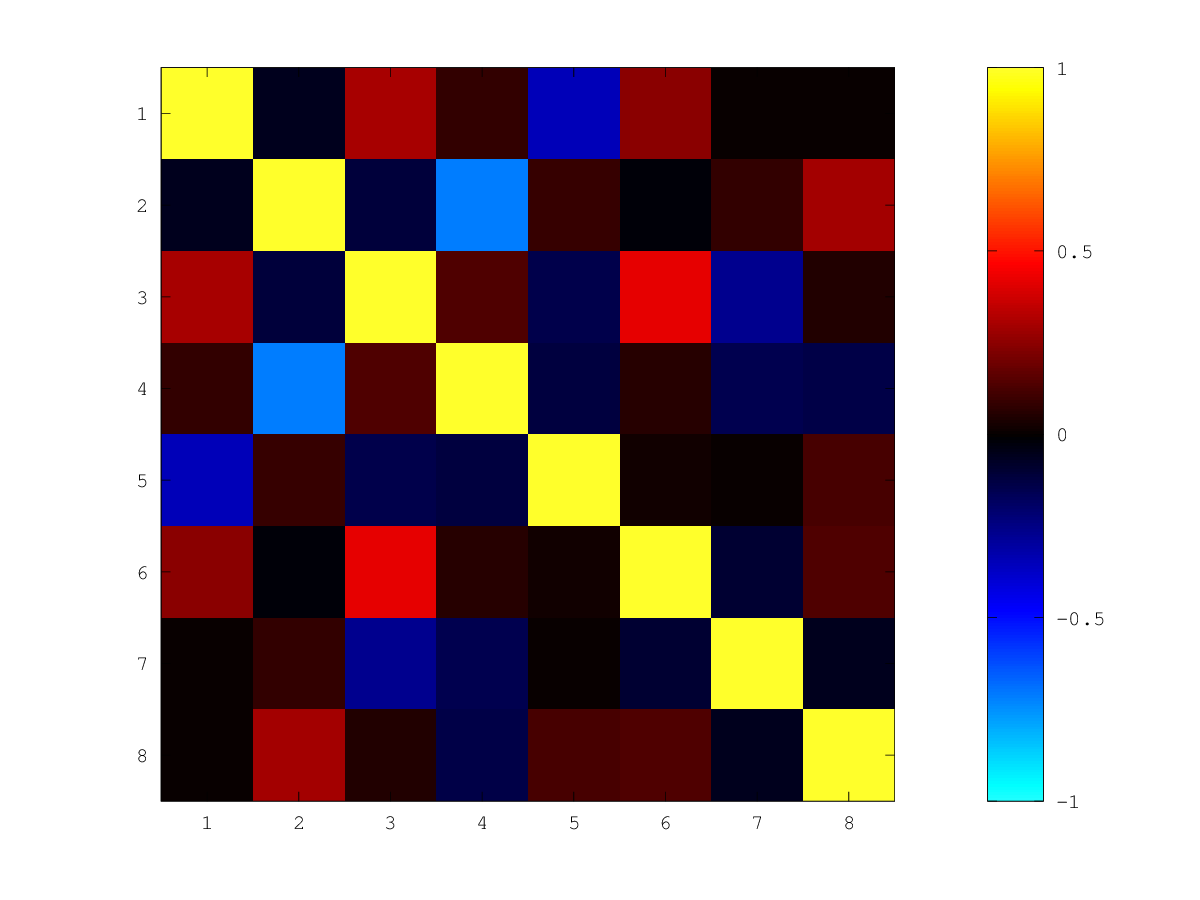

In [30]:
Rc = corr(stack);
title('Spatial correlation matrix of clustered pheno')
niak_visu_matrix(Rc), axis square

In [31]:
Rc

Rc =

 Columns 1 through 6:

   1.0000000  -0.0551635   0.3042343   0.0791410  -0.3463539   0.2454689
  -0.0551635   1.0000000  -0.1168649  -0.7110658   0.0912105  -0.0229521
   0.3042343  -0.1168649   1.0000000   0.1375052  -0.1481517   0.4186051
   0.0791410  -0.7110658   0.1375052   1.0000000  -0.1223070   0.0586590
  -0.3463539   0.0912105  -0.1481517  -0.1223070   1.0000000   0.0207671
   0.2454689  -0.0229521   0.4186051   0.0586590   0.0207671   1.0000000
   0.0048565   0.0832236  -0.2730252  -0.1511642   0.0077422  -0.0970088
   0.0015544   0.2900256   0.0534699  -0.1394386   0.1181863   0.1361457

 Columns 7 and 8:

   0.0048565   0.0015544
   0.0832236   0.2900256
  -0.2730252   0.0534699
  -0.1511642  -0.1394386
   0.0077422   0.1181863
  -0.0970088   0.1361457
   1.0000000  -0.0617030
  -0.0617030   1.0000000

